# 1. Import Libraries

In [236]:
# Customer Churn Prediction - Model Building
# ===============================
# 1. Imports
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import os
import joblib

In [237]:
# 1. Load Data
df = pd.read_csv('DATA/processed/clean_data.csv')
df.head()

# Viewing 

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,1,0,1,1,5,0,2,2,0,2,0,0,0,1,0,1,2,27.43,1
1,0,0,0,0,42,1,1,0,2,2,0,0,1,1,2,0,4,38.28,1
2,1,0,0,0,61,1,1,2,0,2,0,2,2,0,1,0,0,106.44,1
3,1,1,0,1,22,1,0,2,1,1,2,0,1,2,0,0,4,92.49,0
4,1,1,1,1,21,0,0,0,0,0,1,0,0,1,1,0,0,19.63,1


In [238]:
# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Churn rate: {y.mean():.3f}")
print(y.value_counts(normalize=True))

Features shape: (7343, 18)
Target shape: (7343,)
Churn rate: 0.273
Churn
0    0.726542
1    0.273458
Name: proportion, dtype: float64


Counts:
Churn
0    5335
1    2008
Name: count, dtype: int64

Ratios:
Churn
0    0.726542
1    0.273458
Name: proportion, dtype: float64


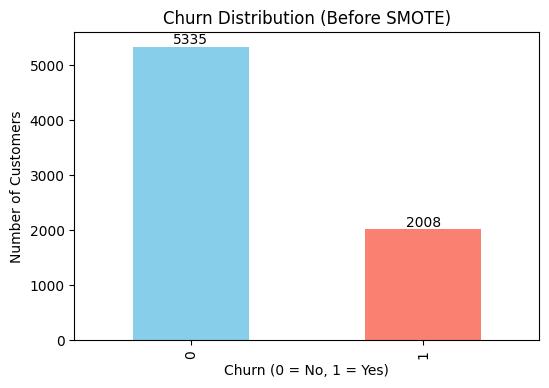

In [239]:
# Count of churn vs no churn
counts = y.value_counts()
ratios = y.value_counts(normalize=True)

print("Counts:")
print(counts)
print("\nRatios:")
print(ratios)

# Plot
plt.figure(figsize=(6,4))
counts.plot(kind="bar", color=["skyblue", "salmon"])
plt.title("Churn Distribution (Before SMOTE)")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Number of Customers")
for i, v in enumerate(counts):
    plt.text(i, v + 50, str(v), ha="center", fontsize=10)
plt.show()


In [240]:
# 2. Split Data
print("\nSplitting data...")

# split into train and test + handle imbalance with SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Train churn rate: {y_train.mean():.3f}")
print(f"Test churn rate: {y_test.mean():.3f}")


Splitting data...
Training set: (8536, 18)
Test set: (1469, 18)
Train churn rate: 0.500
Test churn rate: 0.274


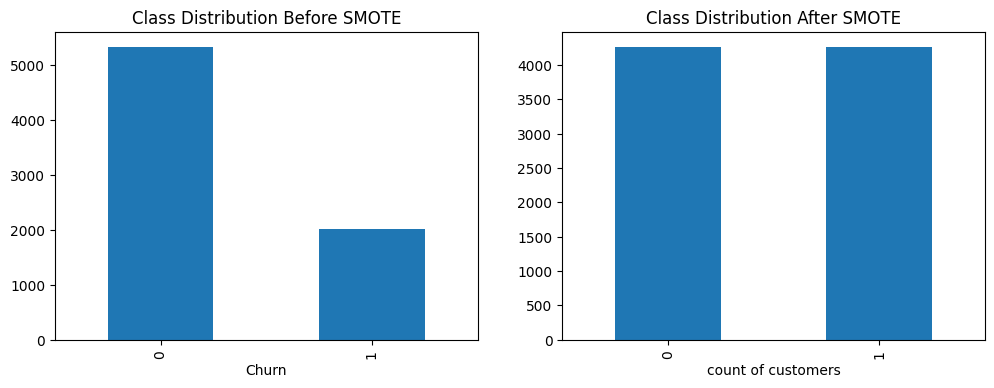

In [241]:
# Plot class distribution before and after SMOTE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
y.value_counts().plot(kind='bar', ax=ax1, title='Class Distribution Before SMOTE')
pd.Series(y_train).value_counts().plot(kind='bar', ax=ax2, title='Class Distribution After SMOTE')
plt.xlabel('count of customers')
plt.show()

In [242]:
# 3. Scale Features (for Logistic Regression)
# Why we use StandardScaler: some algorithms perform better with scaled features
print("\nScaling features...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)




Scaling features...


In [243]:
def train_and_evaluate_cv(X_train, y_train, cv_splits=5):
    """
    Train and evaluate models using Stratified K-Fold cross-validation
    with SMOTE inside the pipeline.
    Returns a DataFrame of mean scores across folds.
    """
    
    models = {
        "Logistic Regression": LogisticRegression(
            max_iter=500, class_weight="balanced", solver="liblinear", random_state=42
        ),
        "Random Forest": RandomForestClassifier(
            n_estimators=200, class_weight="balanced", random_state=42
        ),
        "XGBoost": XGBClassifier(
            n_estimators=200, max_depth=6, learning_rate=0.1,
            use_label_encoder=False, eval_metric="logloss", random_state=42
        )
    }
    
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    
    results = {}
    
    for name, model in models.items():
        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("smote", SMOTE(random_state=42)),  # works inside imblearn pipeline
            ("model", model)
        ])
        
        scoring = ["accuracy", "precision_macro", "recall_macro", "f1_macro", "roc_auc"]
        
        scores = {}
        for metric in scoring:
            cv_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring=metric)
            scores[metric] = cv_scores.mean()
        
        results[name] = scores
    
    return pd.DataFrame(results).T

In [244]:
# 6.  Run Function & Compare Models
results_cv = train_and_evaluate_cv(X_train, y_train, cv_splits=5)
print(results_cv)

c:\Users\YASH\Saved Games\Customer Churn Prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:59:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\YASH\Saved Games\Customer Churn Prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:59:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\YASH\Saved Games\Customer Churn Prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:59:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\YASH\Saved Games\Customer Churn Prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:59:19] WARNING: 

                     accuracy  precision_macro  recall_macro  f1_macro  \
Logistic Regression  0.782684         0.783856      0.782683  0.782467   
Random Forest        0.840205         0.840522      0.840203  0.840168   
XGBoost              0.834816         0.835309      0.834813  0.834754   

                      roc_auc  
Logistic Regression  0.863031  
Random Forest        0.918740  
XGBoost              0.917178  


c:\Users\YASH\Saved Games\Customer Churn Prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:59:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [245]:
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),       # scales numerical features
    ("smote", SMOTE(random_state=42)),  # balances training data
    ("model", RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
        random_state=42
    ))
])

rf_pipeline.fit(X_train, y_train)

y_pred = rf_pipeline.predict(X_test)
y_prob = rf_pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0      0.844     0.834     0.839      1067
           1      0.573     0.592     0.583       402

    accuracy                          0.768      1469
   macro avg      0.709     0.713     0.711      1469
weighted avg      0.770     0.768     0.769      1469

ROC-AUC: 0.8095767647237102


In [246]:
xgb_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("model", XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42
    ))
])

xgb_pipeline.fit(X_train, y_train)

y_pred = xgb_pipeline.predict(X_test)
y_prob = xgb_pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


c:\Users\YASH\Saved Games\Customer Churn Prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:59:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0      0.849     0.818     0.833      1067
           1      0.560     0.614     0.586       402

    accuracy                          0.762      1469
   macro avg      0.705     0.716     0.710      1469
weighted avg      0.770     0.762     0.766      1469

ROC-AUC: 0.8190479187940336


In [247]:
# save the best model (Random Forest here) at models/random_forest_churn.pkl
# Save
# os.makedirs("models", exist_ok=True)
# joblib.dump(rf_pipeline, "models/random_forest_churn.pkl")

# # Load
# loaded_rf = joblib.load("models/random_forest_churn.pkl")

# # Example prediction
# sample_pred = loaded_rf.predict(X_test[:10])
# print("Predictions:", sample_pred)
